# Méthodologie

Lorsque l'on conçoit un modèle d'IA basé sur l'apprentissage automatique, on est généralement amené à tester plusieurs modèles et on doit pouvoir comparer les performances de ces modèles.

Parmi la variété possible sur les modèles tester on a :

* différentes familles de modèles (linéaire, gradient boosting, forêts aléatoires, etc.)
* différents jeux possible d'hyper-paramètres pour une même famille de modèle.

Une méthodologie d'évaluation de modèle complète doit donc faire intervenir :

* Une stratégie d'évaluation de la performance des modèles
* Une stratégie d'exploration des hyper-paramètres

Les deux stratégies pouvant être indépendantes ou se combiner.

## Préparation de l'environnement

In [1]:
DATA_FILE = "initiation-to-ia/data/Titanic/train.csv"

In [2]:
# Retrieve data from GitHub if not present
! if [ ! -f $DATA_FILE ]; then git clone https://github.com/AlexisMignon/initiation-to-ia.git; fi

Clonage dans 'initiation-to-ia'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 46 (delta 15), reused 35 (delta 7), pack-reused 0
Réception d'objets: 100% (46/46), 754.34 Kio | 5.55 Mio/s, fait.
Résolution des deltas: 100% (15/15), fait.


In [3]:
! pip install -r "initiation-to-ia/requirements.txt"

## Evaluation des performances

En apprentissage automatique, il est important de tester les capacités de généralisation d'un modèle, c'est-à-dire, sa capaciter à émettre des prédictions correctes sur des données non vues durant la phase d'apprentissage.

Disposant d'une quantité plus ou moins limités d'exemple, il va donc s'agir d'exploiter au mieux les données disponibles. Le principe de base étant de garder des échantillons de données hors du jeu d'apprentissage afin d'évaluer la performances sur ces échantillons.

Différentes façons de faire sont possibles avec leurs avantages et leurs inconvénients.


### Séparation entrainement / test (train/test split)

La stratégie la plus simple consiste bien sûr à séparer les échantillons d'exemple en deux jeux de donnés fixes.

In [5]:
from sklearn.model_selection import train_test_split
from matplotlib.cm import cmaps_listed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

La méthode du train / test split n'a pas d'object de cross-validation dédié. Le code suivant implémente l'interface des cross-valideurs pour être utilisé comme les autres stratégies.

In [6]:
class TrainTestSplit:
    def __init__(self, stratified=False, **kwargs):
        self.kwargs = kwargs
        self.stratified = stratified
    
    def split(self, X, y, groups=None):
        kwargs = self.kwargs
        if self.stratified:
            if "shuffle" in kwargs and kwargs["shuffle"] is False:
                itrain = []
                itest = []

                for c in np.unique(y):
                    c_train, c_test = train_test_split(np.where(y == c)[0], **kwargs)
                    itrain.append(c_train)
                    itest.append(c_test)
                itrain = np.hstack(itrain)
                itest = np.hstack(itest)
                return [(itrain, itest)]
    
            kwargs = {**kwargs, "stratify": y}
        return [train_test_split(np.arange(len(X)), **kwargs)]

Ci-dessous on a le code de la fonction qui permet d'afficher les indices appartenant aux différentes partitions du jeu de données. C'est une adaptation de la fonction donnée sur le site de scikit-learn.

In [7]:
from matplotlib.patches import Patch

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm


def plot_cv_indices(cv, X, y=None, ax=None, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    if ax is None:
        ax = plt.gca()

    for ii, (tr, tt) in enumerate(cv.split(X, y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )
    n_splits = ii + 1
    
    if y is not None:
        # Plot the data classes and groups at the end
        ax.scatter(
            range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
        )

    # Formatting
    yticklabels = (list(range(n_splits)) if n_splits > 1 else [""]) + ([] if y is None else ["class"])
    ax.set(
        yticks=np.arange(n_splits + (0 if y is None else 1)) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration" if n_splits > 1 else "",
        ylim=[n_splits + (0 if y is None else 1) + 0.2, -0.2],
        xlim=[0, 100]
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    return ax

La stratégie la plus simple consiste à garder un certain nombre de poitns pour l'évaluation de la performance, c'est **le jeu de test** et d'utiliser le reste du jeu de données pour entrainer le modèle, on parle de **jeu d'entrainement**.

Dans la figure qui suit on représente les indices des points de données et on montre en bleu les points attribués au jeu d'entrainement et en rouge ceux attribués au jeu de test.

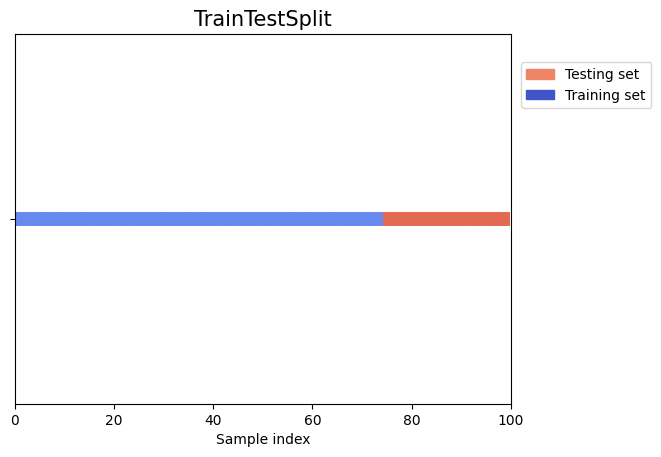

In [8]:
from sklearn.utils import check_random_state

rng = check_random_state(1)

n_points = 100
X = rng.randn(100, 10)

percentiles_classes = [0.1, 0.3, 0.6]
y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

cv = TrainTestSplit(shuffle=False, stratified=False, test_size=0.25)
plot_cv_indices(cv, X, None);

On peut également choisir les points aléatoirement pour éviter certains biais liés à l'ordonnancement des points dans le jeu de données :

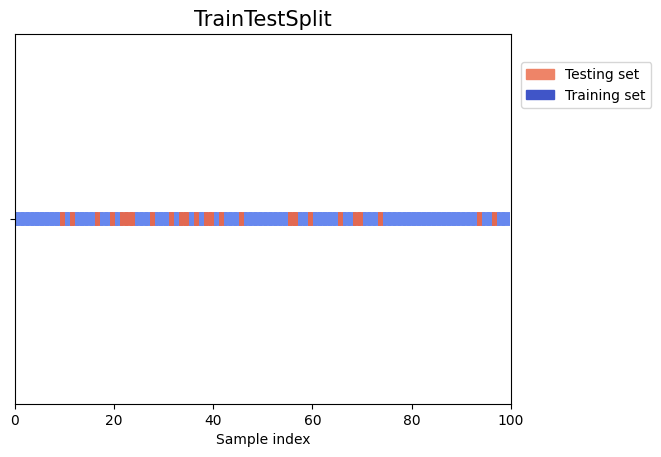

In [9]:
cv = TrainTestSplit(shuffle=True, stratified=False, test_size=0.25, random_state=5)
plot_cv_indices(cv, X, None);

Dans le cas d'un problème de classification, il faut s'assurer que les classes soient soit correctement représentées en train et en test, notamment en cas de déséquilbrage entre classes.

Dans l'exemple qui suit, la ligne inférieur montre la répartition des points en trois classes. On voit que la première classe se retrouve sans représentants dans le jeu de test.

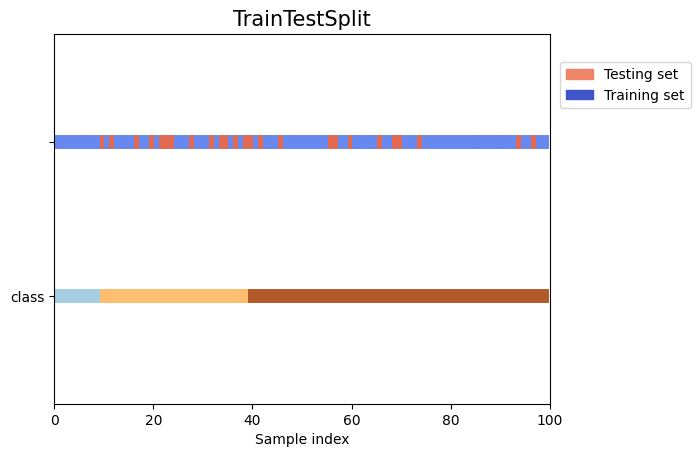

In [10]:
cv = TrainTestSplit(shuffle=True, stratified=False, test_size=0.25, random_state=5)
plot_cv_indices(cv, X, y);

La stratégie habituellement utilisée consiste à la séparation (aléatoire ou non) indépendamment pour chaque classe. On appelle cette procédure la **stratification**.

L'exemple suivant illustre une stratification sans mélange :

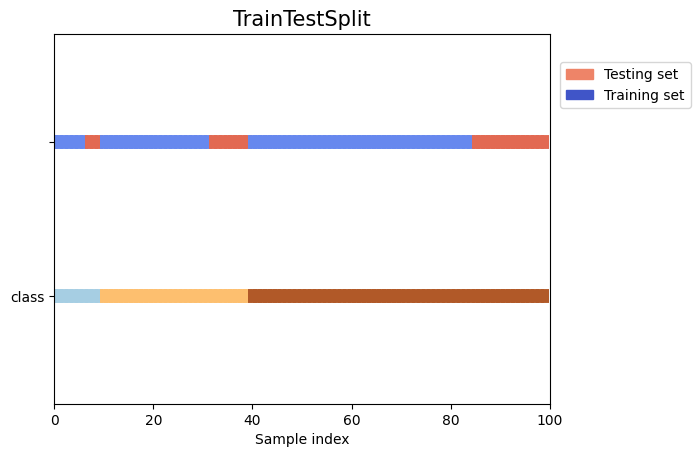

In [11]:
cv = TrainTestSplit(shuffle=False, stratified=True, test_size=0.25)
plot_cv_indices(cv, X, y);

L'exemple suivant correspond à une stratification avec tirage aléatoire :

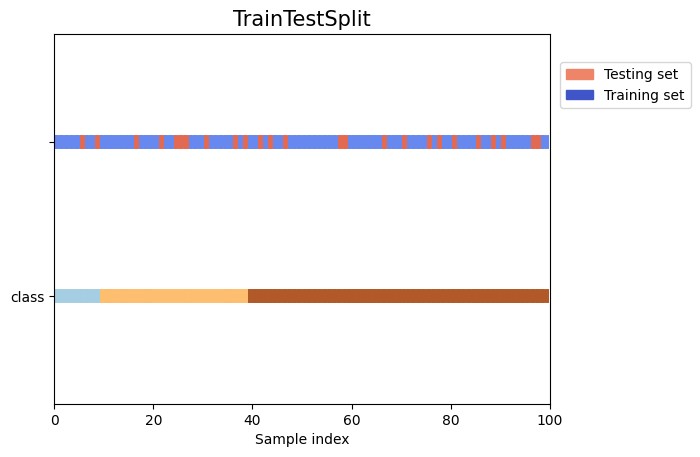

In [12]:
cv = TrainTestSplit(shuffle=True, stratified=True, test_size=0.25, random_state=5)
plot_cv_indices(cv, X, y);

Avec cette stratégie d'évaluation, le score n'est calculé que sur sous-partie des données et n'est peut-être pas représentatif du score obtenu sur de nouvelles données. Plus la taille du jeu de test est importante plus le score pourrait être représentatif mais en même temps plus la taille du jeu d'entrainement diminue plus la performance attendue du modèle se dégrade.

Un équilibre doit donc être trouvé afin d'avoir à la fois un modèle proche de celui entrainé sur le jeu de données complet et une mesure de performance représentative.

### Validation à K sous-ensembles (K-fold cross validation)

La stratégie de validation croisée à K sous-ensemble tente de résoudre le problème de la fiabilité de la mesure de performance. L'idée est que tous les points du jeu de données seront utilisés pour l'évaluation.

Pour cela on sépare le jeu de données en K sous-ensembles et chaque sous ensemble est utilisé à tour de rôle comme jeu de test le reste des données étant utilisée pour entrainer un modèle.

On va donc entrainer K modèles.

La stratégie est illustrée dans la figure suivante :

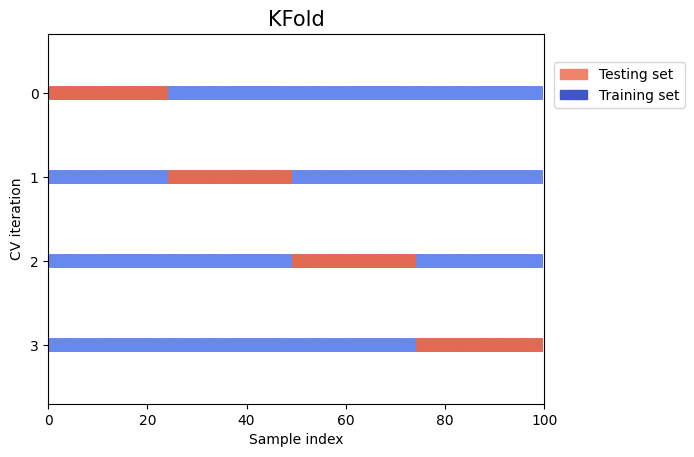

In [13]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=4)
plot_cv_indices(cv, X, None);

Le même principe peut être appliqué avec une stratification par classe dans le cas d'un problème de classification :

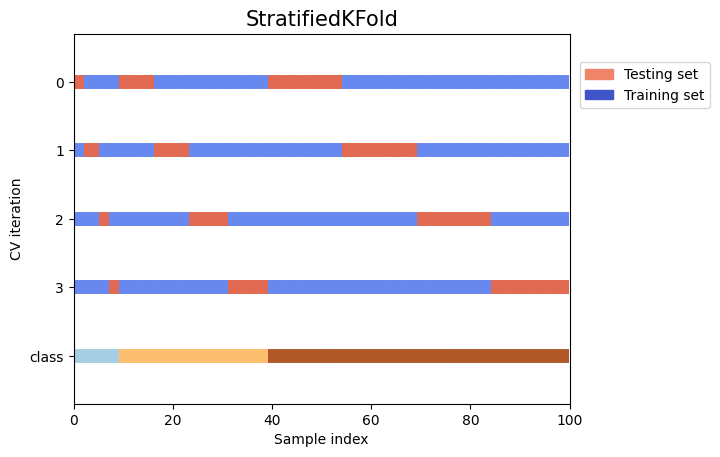

In [14]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=4)
plot_cv_indices(cv, X, y);

Et le choix peut-être effectué aléatoirement pour chaque classe :

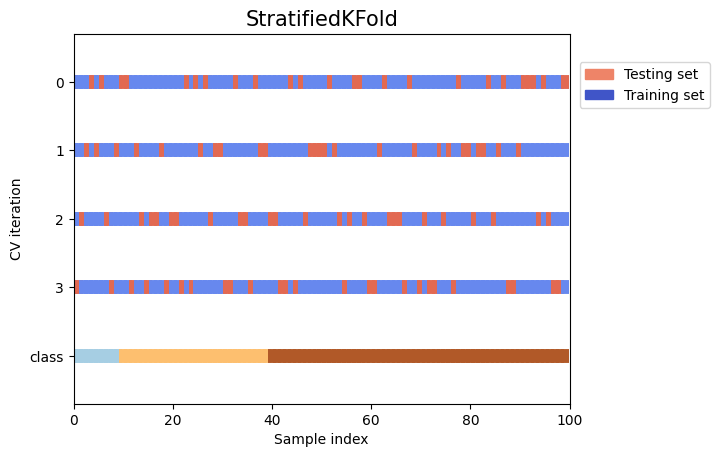

In [15]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
plot_cv_indices(cv, X, y);

Cette stratégie résoud donc le problème de la représentativité du score de performance car tous les points sont utilisés pour l'estimation de cette performance.

Le choix du nombre de sous-ensembles reste important car plus le nombre de sous-ensemble est grand, plus la taille du jeu d'entrainement est proche de la taille du jeu complet et plus les modèles entrainés auront des performances proches.

Un compromis doit toutefois être tranché pour éviter d'avoir à entrainer un nombre de modèles trop important.

## Optimisation des hyper-paramètres et évaluation de performance

Les hyper-paramètres d'un modèle doivent être fixés avant l'entrainement mais ont une importance capitale pour la performance du modèle. Il est donc nécessaire de tester plusieurs combinaisons d'hyper-paramètre et de choisir la combinaison qui donne la meilleur mesure de performance. 

La procédure d'optimisation des hyper-paramètres ne devrait pas être réalisées en utilisant le jeu de données de test pour mesurer la performance faute de quoi, on peut **sur-apprendre** le jeu de donné optimal. Il est donc souhaitable de découpler la procédure d'optimisation des hyper-paramètres de l'évaluation de score finale.



La figure suivante montre un choix classique de procédure d'évaluation :

1. L'évaluation finale est réalisée avec une approche train / test
2. L'optimisation des hyper-paramètres est réalisée avec une approche à K sous-ensembles.

![Validation croisée avec recherche d'hyper-paramètres](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

Si la procédure d'évaluation utilisée pour choisir les hyper-paramètres implique $K$ évaluations et qu'il faut tester $P$ combinaisons d'hyper-paramètres, alors il faudra entrainer $K\times P$ modèles, pour la procédure de sélection des hyper-paramètres.


D'autres combinaisons sont possibles comme par exemple deux validations croisées à K sous-ensembles imbriquées. Le choix des stratégies d'évaluation étant généralement guider par le nombre d'entrainements de modèles impliqués.


## Stratégies de recherche d'hyper-paramètres

Pour trouver la meilleurs combinaison d'hyper-paramètres nous devons en essayer plusieurs et évaluer la performance obtenue avec chacune. Le choix des valeurs d'hyper-paramètres à tester est donc important et plussieurs stratégies sont possibles

### Recherche par grille (grid search)

Dans la recherche par grille on propose, pour chaque hyper-paramètre, un ensemble de valeurs à tester et on génère toutes les combinaisons possibles :

In [16]:
from itertools import product

param_grid = {
    "param1": [1.0, 2.0, 3.0],
    "param2": [5, 7],
    "param3": ["a", "b"]
}

[dict(zip(param_grid.keys(), values)) for values in product(*param_grid.values())]

[{'param1': 1.0, 'param2': 5, 'param3': 'a'},
 {'param1': 1.0, 'param2': 5, 'param3': 'b'},
 {'param1': 1.0, 'param2': 7, 'param3': 'a'},
 {'param1': 1.0, 'param2': 7, 'param3': 'b'},
 {'param1': 2.0, 'param2': 5, 'param3': 'a'},
 {'param1': 2.0, 'param2': 5, 'param3': 'b'},
 {'param1': 2.0, 'param2': 7, 'param3': 'a'},
 {'param1': 2.0, 'param2': 7, 'param3': 'b'},
 {'param1': 3.0, 'param2': 5, 'param3': 'a'},
 {'param1': 3.0, 'param2': 5, 'param3': 'b'},
 {'param1': 3.0, 'param2': 7, 'param3': 'a'},
 {'param1': 3.0, 'param2': 7, 'param3': 'b'}]

Les choix des valeurs à tester reste toutefois arbitraire et est souvent guidé par des essais manuels préalables.

Le nombre de combinaisons à tester peut donc rapidement exploser en fonction du nombre de paramètres et du nombre de valeurs proposées.

Avec $N_p$ paramètres et $n_i$ valeurs à tester pour le paramètre $i$ on a donc un nombre de combinaisons à tester $P$ :

$$ P = \prod_{i=1}^{N_p} p_i = p_1 \times \dots \times p_{N_p}$$

### Recherche aléatoire (randomized search)

Dans une recherche aléatoire on donne une distribution pour chacun des hyper-paramètres. Le nombre de combinaisons $P$ à tester est alors fixé et pour chaque combinaison on tire aléatoirement une valeur de chaque hyper-paramètre depuis la distribution associée :

In [17]:
from scipy.stats import loguniform, nbinom, uniform, multinomial, randint

class multinomial_uniform:
    def __init__(self, values):
        self.values = np.array(values)
        self.uniform = randint(0, len(values))

    def rvs(self, *args, size=None, **kwargs):
        return self.values[
            self.uniform.rvs(*args, **kwargs)
        ]

param_distribs = {
    "param1": loguniform(0.1, 10.),
    "param2": nbinom(2.0, 0.7),
    "param3": multinomial_uniform(["a", "b", "c"])
}

np.random.seed(1)

n_iter = 10
params = [
    {name: dist.rvs() for name, dist in param_distribs.items()}
    for _ in range(n_iter)
]
params

[{'param1': 0.6824078427098832, 'param2': 0, 'param3': 'b'},
 {'param1': 2.1852044366982226, 'param2': 1, 'param3': 'a'},
 {'param1': 0.2563920173316309, 'param2': 0, 'param3': 'a'},
 {'param1': 3.6039476397777395, 'param2': 1, 'param3': 'b'},
 {'param1': 5.659503131926904, 'param2': 1, 'param3': 'a'},
 {'param1': 3.6866248434672557, 'param2': 0, 'param3': 'c'},
 {'param1': 9.499968774647312, 'param2': 0, 'param3': 'a'},
 {'param1': 0.8679147174590263, 'param2': 1, 'param3': 'b'},
 {'param1': 0.1469758596743518, 'param2': 2, 'param3': 'a'},
 {'param1': 0.16020234085819765, 'param2': 0, 'param3': 'a'}]

### Optimisation Bayésienne

La recherche aléatoire permet de mieux explorer l'espace des hyper-paramètres mais n'exploite pas la connaissance acquise par les différents essais succéssifs.

Intuitivement, on se dit qu'une bonne stratégie d'exploration devrait explorer en priorité :

* les zones non déjà explorées
* les zones donnant déjà de bon résultats

L'optimisation bayésienne cherche à atteindre ce type de stratégies en construisant au fur et à mesure des essais une approximation de la fonction liant les hyper-paramètres au score de performance. Une des spécificité est que cette approximation est données sous forme d'une distribution qui reflète l'incertitude sur le score attendu pour un jeu d'hyper-paramètres donné.

Dans le panel du haut de l'illustration suivante on montre :

* la vraie fonction de score simulée:  ligne noire
* les points déjà évalués : point noires
* l'approximation courante avec :
    * sa valeur moyenne : ligne violette épaisse
    * sa distribution : gradient violet
    * une limite haute de l'estimation de la 
    
Cette **distribution prédictive** peut alors être exploitée de diverse manière qui correspondent aux trois graphes du dessous. Le losange jaune montrant pour chacune des méthodes la proposition du modèle.

Les trois critères montrés sont :

* L'amélioration espérée au sens de l'espérance mathématique
* La limite haute de confiance correspond à un certain quantile (haut) de la distribution
* La probabilité d'amélioration


![Optimisation Bayésienne](https://upload.wikimedia.org/wikipedia/commons/0/02/GpParBayesAnimationSmall.gif)

## Titanic

Nous allons maintenant appliquer ces méthodes sur les données Titanic.
Commençons par charger les données :

In [18]:
import pandas as pd

df = pd.read_csv(DATA_FILE).dropna()
# On garde d'un côté les variables explicatives
# On retire donc la variables cibles mais aussi les identifiants
# ainsi que deux colonnes non-informatives (Nom et numéro de tickets)
X = df.drop(["PassengerId", "Name", "Ticket", "Survived"], axis=1)
# On récupère la cible
y = df.Survived

On identifie les colonnes catégorielles qui nécessitent un traitement spécifique :

In [19]:
# Les colonnes encoder comme des chaines de caractères sont
# considérées comme catégorielles

cat_columns = [c for c in X.columns if X.dtypes[c] == "object"]

### Le protocol d'évaluation

Nous allon utilisée le protocole décrit plus haut :

1. Une séparation entrainement / test pour l'évaluation finale
2. Une validation croisée à 4 sous-ensembles pour la sélection des hyper-paramètres

Puisqu'il s'agit d'un problème de classificatoin nous allons recourrir à la stratification pour assurer l'iso-répartition des classes entre les jeux d'entrainement et de test.


In [20]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import check_random_state

# Séparation entrainement / test pour l'évaluation finale
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=True, stratify=y, random_state=1)

# Validation croisée stratifiée à 4 sous-ensembles pour la recherche d'hyper-paramètres
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=2)

# On peut utiliser plusieurs processeurs si disponibles
n_jobs=5

### Les modèles

#### Classification linéaire

Nous allons tester un modèle de classification linéaire. Le plus courant est le modèle de régression logistique. Toutefois nous allons d'abord procéder à quelques prétraitements :

* numériser les variables catégorielles avec l'encodage de cible
* effectuer une expansion polynomiale pour capturer d'éventuelles relations non linéaires
* standardiser (retirer la moyenne et diviser par l'écart-type) les variables pour qu'elles aient toutes la même échelle.

Pour cela nous pouvons utiliser un `Pipeline`. Ceci nous permet de grouper en un seul object, des étapes de prétraitement et un modèle supervisé :

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from category_encoders import TargetEncoder

logist_model = Pipeline([
    ("cat_enc", TargetEncoder(cols=cat_columns, min_samples_leaf=5, smoothing=1.0)),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("std", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, verbose=0))
])

Notez la manière de déclarer les éléments de la chaîne de traitement sous forme de tuples avec un nom et l'estimateur ensuite.

Ceci nous permettra, lors de la recherche des hyper-paramètres, d'adresser les hyper-paramètres de n'importe quel élément de la chaine.

#### Classification par arbre de décision

Les arbres de décision sont naturellement capables de capturer les relations non-linéaires et sont insensibles aux transformations monotones des variables. La seule étape de prétraitement nécessaire sera donc l'encodage des données catégorielles :

In [22]:
from sklearn.ensemble import RandomForestClassifier

tree_model = Pipeline([
    ("cat_enc", TargetEncoder(cols=cat_columns)),
    ("clf", RandomForestClassifier())
])

#### CatBoost

CatBoost est une variante de gradient boosting embarquant un traitement spécifique des données catégorielles (le "Cat" de "CatBoost"). Pour rappel les modèles de gradient boosting construise de manière itérative un ensemble de modèles, le plus souvent des arbres de décision, dont la tâche est de corriger les erreurs du modèles précédent.

Basés sur les arbres de décision, le modèle CatBoost :

* peut capturer les relations non-linéaires
* est insensibles aux transformations monotones des variables
* est capable de gérer les variables catégorielles

Il peut donc être utilisé directement sans l'inclure dans un `Pipeline`:

In [23]:
from catboost import  CatBoostClassifier

boost_model = CatBoostClassifier(cat_features=cat_columns, verbose=False)

### La recherche par grille (grid search)

La recherche par grille consiste à affecter, pour chaque hyper-paramètre inspecté, une liste de valeurs à tester. Le choix des valeurs reste plus ou moins arbitraires. Une pratique courante consiste à faire une première recherche "à la main" pour trouver un ensemble de paramètres qui semble bien fonctionner, et ensuite de scanner autour des valeurs trouvées.

Le code ci-dessous montre les valeurs de paramètres testées pour un sous-ensembles d'hyper-paramètres (ceux connus pour être important pour le score final).

#### Modèle linéaire

Le modèle linéaire est donc en fait composé de plusieurs étapes, dont certaines ont également des paramètres à déterminer.

L'encodage des données catégorielles est réalisée par encodage de la cible, c'est à dire que basiquement on va
calculer la moyenne de la cible pour tous les points 

In [24]:
logist_param_grid = {
    "cat_enc__smoothing": [0.5, 1.0, 5.0],
    "cat_enc__min_samples_leaf": [5, 10, 20],
    "poly__degree": [2, 3, 4],
    "clf__C": [0.001, 0.01, 0.1]
}

Notez la manière de déclarer les listes de valeurs sous forme de dictionnaire (tableau associatif). Le nom du paramètres à scanner est donnée en concaténant le nom de l'élément de le pipeline et le nom du paramètre pour l'élément (avec un double "_" entre les deux)

La recherche par grille va donc consister à tester toutes les combinaisons possibles de ces paramètres ce qui donne
$3 \times 3 \times 3 \times 3 = 81$ combinaisons possibles.

On peut appliquer la recherche sur grille avec validation croisée stratifiée en utilisant l'object  `GridSearchCV` :

In [25]:
from sklearn.model_selection import GridSearchCV

logist_grid_cv = GridSearchCV(
    estimator=logist_model,
    param_grid=logist_param_grid,
    cv=cv,
    n_jobs=n_jobs
)

logist_grid_cv.fit(Xtrain, ytrain)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=2, shuffle=True),
             estimator=Pipeline(steps=[('cat_enc',
                                        TargetEncoder(cols=['Sex', 'Cabin',
                                                            'Embarked'],
                                                      min_samples_leaf=5)),
                                       ('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('std', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=5,
             param_grid={'cat_enc__min_samples_leaf': [5, 10, 20],
                         'cat_enc__smoothing': [0.5, 1.0, 5.0],
                         'clf__C': [0.001, 0.01, 0.1],
                         'poly__degree': [2, 3, 4]})

L'objet s'utilise comme un estimateur scikit-learn classique. En interne, il va utiliser la stratégie de validation croisée données en argument pour évaluer la performance associée à chaque combinaison d'hyper-paramètres.

Puique nous utilisons une validation croisée à 4 sous-ensemble il y aura donc en tout $81\times 4 = 324$ modèles entrainés et testés. Un 325 ème modèle sera par ailleur entrainer sur l'ensemble des données d'entrainement avec le meilleur jeu d'hyper-paramètres trouvé.

Ce jeu d'hyper-paramètres est accessible par un attribut du modèle après apprentissage :

In [26]:
logist_grid_cv.best_params_

{'cat_enc__min_samples_leaf': 5,
 'cat_enc__smoothing': 1.0,
 'clf__C': 0.1,
 'poly__degree': 3}

On voit notamment que le degré de l'expansion polynomial ainsi que le paramètre de régularisation de la régression logistique correspondent aux limites des valeurs de la grille. Cela implique qu'une recherche au-delà de ces valeurs peut être pertinente.

Nous avons alors accès au score associé à cette combinaison :

In [27]:
print("Meilleur score: ", logist_grid_cv.best_score_)

Meilleur score:  0.751890756302521


Par défault, scikit-learn utilise le taux de classification correcte (accuracy). Une autre mesure de performance peut être spécifiée.

#### Arbre de décision

In [28]:
tree_param_grid = {
    "cat_enc__smoothing": [0.5, 1.0, 5.0],
    "cat_enc__min_samples_leaf": [2, 5, 10, 20],
    "clf__n_estimators": [5, 10, 20, 50],
    "clf__max_depth": [None, 5, 11, 21],
    "clf__min_samples_leaf": [2, 5, 10, 20]
}

In [29]:
tree_grid_cv = GridSearchCV(
    estimator=tree_model,
    param_grid=tree_param_grid,
    cv=cv,
    n_jobs=n_jobs
)

tree_grid_cv.fit(Xtrain, ytrain)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=2, shuffle=True),
             estimator=Pipeline(steps=[('cat_enc',
                                        TargetEncoder(cols=['Sex', 'Cabin',
                                                            'Embarked'])),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=5,
             param_grid={'cat_enc__min_samples_leaf': [2, 5, 10, 20],
                         'cat_enc__smoothing': [0.5, 1.0, 5.0],
                         'clf__max_depth': [None, 5, 11, 21],
                         'clf__min_samples_leaf': [2, 5, 10, 20],
                         'clf__n_estimators': [5, 10, 20, 50]})

In [30]:
print("Meilleur score: ", tree_grid_cv.best_score_)
tree_grid_cv.best_params_

Meilleur score:  0.7735294117647059


{'cat_enc__min_samples_leaf': 20,
 'cat_enc__smoothing': 5.0,
 'clf__max_depth': 21,
 'clf__min_samples_leaf': 10,
 'clf__n_estimators': 5}

In [31]:
boost_param_grid = {
    "iterations": [10, 20, 50],
    "depth": [2, 3, 5],
    "min_data_in_leaf": [1, 2, 5]
}

In [32]:
boost_grid_cv = GridSearchCV(
    estimator=boost_model,
    param_grid=boost_param_grid,
    cv=cv,
    n_jobs=n_jobs
)

boost_grid_cv.fit(Xtrain, ytrain)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=2, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x7fe66b15fe20>,
             n_jobs=5,
             param_grid={'depth': [2, 3, 5], 'iterations': [10, 20, 50],
                         'min_data_in_leaf': [1, 2, 5]})

In [33]:
print("Meilleur score: ", boost_grid_cv.best_score_)
boost_grid_cv.best_params_

Meilleur score:  0.759453781512605


{'depth': 3, 'iterations': 20, 'min_data_in_leaf': 1}

### Recherche randomisée

On l'a vu, le nombre de modèles à entrainter dans une recherche sur grille peut rapidement exploser lorsque le nombre d'hyper-paramètre à tester augmente.

Pour réduire cette charge dans un espace d'hyper-paramètres à grande dimension, on peut effectuer une recherche aléatoire. Pour cela, on donne à chaque hyper-paramètre une distribution depuis laquelle on pourra tirer aléatoirement une valeur.

On peut alors fixer à l'avance le nombre d'essais et pour chaque essai, on tire une valeur pour chaque hyper-paramètre depuis la distribution associée.

In [34]:
from scipy.stats import loguniform
import numpy as np

logist_param_distribs = {
    "cat_enc__smoothing": loguniform(1e-2, 1e1),
    "cat_enc__min_samples_leaf": np.arange(1, 51),
    "poly__degree": np.arange(1, 6),
    "clf__C": loguniform(1e-3, 1e3)
}

tree_param_distribs = {
    "cat_enc__smoothing": loguniform(1e-2, 1e1),
    "cat_enc__min_samples_leaf": np.arange(1, 51),
    "clf__max_depth": np.arange(1, 51),
    "clf__min_samples_leaf": np.arange(1, 51)   
}

boost_param_distribs = {
    "iterations": np.arange(5, 100),
    "depth": np.arange(2, 16),
    "min_data_in_leaf": np.arange(1, 51) 
}

Modèle de régression logistique :

In [35]:
from sklearn.model_selection import RandomizedSearchCV

logist_rand_cv = RandomizedSearchCV(
    estimator=logist_model,
    param_distributions=logist_param_distribs,
    cv=cv,
    n_iter=200,
    n_jobs=n_jobs
).fit(Xtrain, ytrain)

/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_o

/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/

/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/

/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/

/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*in

/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/

/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_o

In [36]:
print("Meilleur score: ", logist_rand_cv.best_score_)
logist_rand_cv.best_params_

Meilleur score:  0.7737394957983192


{'cat_enc__min_samples_leaf': 5,
 'cat_enc__smoothing': 2.0726887426218505,
 'clf__C': 279.83054288230915,
 'poly__degree': 5}

Arbre de décision :

In [37]:
tree_rand_cv = RandomizedSearchCV(
    estimator=tree_model,
    param_distributions=tree_param_distribs,
    cv=cv,
    n_iter=100,
    n_jobs=n_jobs
).fit(Xtrain, ytrain)

/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/

/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/

/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/

/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/amignon/Projets/upec-introduction-to-ai/shared_notebooks/venv/lib/python3.10/site-packages/pandas/

In [38]:
print("Meilleur score: ", tree_rand_cv.best_score_)
tree_rand_cv.best_params_

Meilleur score:  0.7588235294117648


{'cat_enc__min_samples_leaf': 45,
 'cat_enc__smoothing': 1.025770241883158,
 'clf__max_depth': 22,
 'clf__min_samples_leaf': 1}

CatBoost :

In [39]:
boost_rand_cv = RandomizedSearchCV(
    estimator=boost_model,
    param_distributions=boost_param_distribs,
    cv=cv,
    n_iter=100,
    n_jobs=n_jobs
).fit(Xtrain, ytrain)

In [40]:
print("Meilleur score: ", boost_rand_cv.best_score_)
boost_rand_cv.best_params_

Meilleur score:  0.7665966386554622


{'min_data_in_leaf': 44, 'iterations': 66, 'depth': 9}

### Optimisation Bayesienne

Pour l'optimisation Bayésienne nous utilisons la bibliothèque `optuna`, qui a l'avantage de proposer une interface compatible avec scikit-learn. La déclaration est très similaire à cellle utilisée pour la recherche randomisée mais utilise des objets distributions spécifique à la bibliothèque :

In [41]:
from optuna.distributions import FloatDistribution, IntDistribution

logist_param_distribs_opt = {
    "cat_enc__smoothing": FloatDistribution(1e-2, 1e1, log=True),
    "cat_enc__min_samples_leaf": IntDistribution(1, 50),
    "poly__degree": IntDistribution(1, 5),
    "clf__C": FloatDistribution(1e-3, 1e3, log=True)
}

tree_param_distribs_opt = {
    "cat_enc__smoothing": FloatDistribution(1e-2, 1e1, log=True),
    "cat_enc__min_samples_leaf": IntDistribution(1, 50),
    "clf__max_depth": IntDistribution(1, 50),
    "clf__min_samples_leaf": IntDistribution(1, 50)   
}

boost_param_distribs_opt = {
    "iterations": IntDistribution(5, 100),
    "depth": IntDistribution(2, 16),
    "min_data_in_leaf": IntDistribution(1, 50) 
}

Il nous reste simplement a effectuée la recherche pour les trois familles de modèles.

Voici le code pour la régression logique :

In [42]:
from optuna.integration.sklearn import OptunaSearchCV

logist_opt_cv = OptunaSearchCV(
    estimator=logist_model,
    param_distributions=logist_param_distribs_opt,
    cv = cv,
    n_trials=100
).fit(Xtrain, ytrain)

[I 2022-11-28 15:02:46,424] A new study created in memory with name: no-name-cf09544b-8454-436c-815c-cb394159a78f
[I 2022-11-28 15:02:47,375] Trial 0 finished with value: 0.7006302521008404 and parameters: {'cat_enc__smoothing': 0.08685296003222023, 'cat_enc__min_samples_leaf': 25, 'poly__degree': 4, 'clf__C': 0.0013771526305129055}. Best is trial 0 with value: 0.7006302521008404.
[I 2022-11-28 15:02:48,541] Trial 1 finished with value: 0.700420168067227 and parameters: {'cat_enc__smoothing': 0.24987678978777955, 'cat_enc__min_samples_leaf': 33, 'poly__degree': 2, 'clf__C': 205.33731133070964}. Best is trial 0 with value: 0.7006302521008404.
[I 2022-11-28 15:02:50,320] Trial 2 finished with value: 0.7006302521008403 and parameters: {'cat_enc__smoothing': 0.012283721117079963, 'cat_enc__min_samples_leaf': 16, 'poly__degree': 4, 'clf__C': 0.419376148645163}. Best is trial 0 with value: 0.7006302521008404.
[I 2022-11-28 15:02:51,471] Trial 3 finished with value: 0.7298319327731093 and par

[I 2022-11-28 15:04:19,887] Trial 29 finished with value: 0.7155462184873951 and parameters: {'cat_enc__smoothing': 0.558059730048953, 'cat_enc__min_samples_leaf': 24, 'poly__degree': 5, 'clf__C': 164.43828713048984}. Best is trial 8 with value: 0.7592436974789916.
[I 2022-11-28 15:04:25,588] Trial 30 finished with value: 0.7226890756302522 and parameters: {'cat_enc__smoothing': 0.6318891362442468, 'cat_enc__min_samples_leaf': 29, 'poly__degree': 4, 'clf__C': 434.46373397408564}. Best is trial 8 with value: 0.7592436974789916.
[I 2022-11-28 15:04:30,432] Trial 31 finished with value: 0.7588235294117647 and parameters: {'cat_enc__smoothing': 1.5565365515801504, 'cat_enc__min_samples_leaf': 37, 'poly__degree': 4, 'clf__C': 319.0507295534733}. Best is trial 8 with value: 0.7592436974789916.
[I 2022-11-28 15:04:34,443] Trial 32 finished with value: 0.7590336134453782 and parameters: {'cat_enc__smoothing': 3.299525072429191, 'cat_enc__min_samples_leaf': 35, 'poly__degree': 4, 'clf__C': 167.

[I 2022-11-28 15:06:33,843] Trial 59 finished with value: 0.7226890756302521 and parameters: {'cat_enc__smoothing': 0.05675847779543199, 'cat_enc__min_samples_leaf': 23, 'poly__degree': 5, 'clf__C': 64.65861577282413}. Best is trial 36 with value: 0.788235294117647.
[I 2022-11-28 15:06:39,026] Trial 60 finished with value: 0.7661764705882353 and parameters: {'cat_enc__smoothing': 1.0973578689666006, 'cat_enc__min_samples_leaf': 19, 'poly__degree': 5, 'clf__C': 47.13850223169512}. Best is trial 36 with value: 0.788235294117647.
[I 2022-11-28 15:06:47,915] Trial 61 finished with value: 0.7808823529411764 and parameters: {'cat_enc__smoothing': 4.28638160112266, 'cat_enc__min_samples_leaf': 15, 'poly__degree': 5, 'clf__C': 222.3936165576045}. Best is trial 36 with value: 0.788235294117647.
[I 2022-11-28 15:06:56,257] Trial 62 finished with value: 0.788235294117647 and parameters: {'cat_enc__smoothing': 4.02776606667873, 'cat_enc__min_samples_leaf': 15, 'poly__degree': 5, 'clf__C': 252.3471

[I 2022-11-28 15:09:54,890] Trial 89 finished with value: 0.7735294117647059 and parameters: {'cat_enc__smoothing': 5.082516888743073, 'cat_enc__min_samples_leaf': 13, 'poly__degree': 5, 'clf__C': 45.375081574491546}. Best is trial 63 with value: 0.7955882352941176.
[I 2022-11-28 15:09:59,313] Trial 90 finished with value: 0.7590336134453782 and parameters: {'cat_enc__smoothing': 4.191280907176627, 'cat_enc__min_samples_leaf': 18, 'poly__degree': 4, 'clf__C': 220.7540622544253}. Best is trial 63 with value: 0.7955882352941176.
[I 2022-11-28 15:10:06,043] Trial 91 finished with value: 0.7806722689075629 and parameters: {'cat_enc__smoothing': 7.142154067465965, 'cat_enc__min_samples_leaf': 21, 'poly__degree': 5, 'clf__C': 368.1001251645489}. Best is trial 63 with value: 0.7955882352941176.
[I 2022-11-28 15:10:13,615] Trial 92 finished with value: 0.7808823529411765 and parameters: {'cat_enc__smoothing': 4.63581713513691, 'cat_enc__min_samples_leaf': 19, 'poly__degree': 5, 'clf__C': 179.9

In [43]:
print("Score: ", logist_opt_cv.best_score_)
logist_opt_cv.best_params_

Score:  0.7955882352941176


{'cat_enc__smoothing': 4.169026896107697,
 'cat_enc__min_samples_leaf': 19,
 'poly__degree': 5,
 'clf__C': 240.63607182762362}

L'arbre de décision :

In [44]:
tree_opt_cv = OptunaSearchCV(
    estimator=tree_model,
    param_distributions=tree_param_distribs_opt,
    cv = cv,
    n_trials=100
).fit(Xtrain, ytrain)

[I 2022-11-28 15:10:46,828] A new study created in memory with name: no-name-b4f788d4-c898-43a6-a169-01c51e46b4bd
[I 2022-11-28 15:10:48,533] Trial 0 finished with value: 0.6716386554621849 and parameters: {'cat_enc__smoothing': 6.550585042811388, 'cat_enc__min_samples_leaf': 19, 'clf__max_depth': 9, 'clf__min_samples_leaf': 33}. Best is trial 0 with value: 0.6716386554621849.
[I 2022-11-28 15:10:50,453] Trial 1 finished with value: 0.6789915966386555 and parameters: {'cat_enc__smoothing': 0.023461015718460675, 'cat_enc__min_samples_leaf': 46, 'clf__max_depth': 16, 'clf__min_samples_leaf': 19}. Best is trial 1 with value: 0.6789915966386555.
[I 2022-11-28 15:10:52,024] Trial 2 finished with value: 0.6716386554621849 and parameters: {'cat_enc__smoothing': 0.4327748403889183, 'cat_enc__min_samples_leaf': 3, 'clf__max_depth': 10, 'clf__min_samples_leaf': 31}. Best is trial 1 with value: 0.6789915966386555.
[I 2022-11-28 15:10:53,728] Trial 3 finished with value: 0.6716386554621849 and par

[I 2022-11-28 15:11:42,529] Trial 29 finished with value: 0.7010504201680672 and parameters: {'cat_enc__smoothing': 0.07013225915410966, 'cat_enc__min_samples_leaf': 29, 'clf__max_depth': 33, 'clf__min_samples_leaf': 5}. Best is trial 25 with value: 0.7592436974789916.
[I 2022-11-28 15:11:44,645] Trial 30 finished with value: 0.6716386554621849 and parameters: {'cat_enc__smoothing': 0.058593874541255614, 'cat_enc__min_samples_leaf': 44, 'clf__max_depth': 38, 'clf__min_samples_leaf': 50}. Best is trial 25 with value: 0.7592436974789916.
[I 2022-11-28 15:11:46,459] Trial 31 finished with value: 0.7445378151260504 and parameters: {'cat_enc__smoothing': 4.88050774623821, 'cat_enc__min_samples_leaf': 36, 'clf__max_depth': 43, 'clf__min_samples_leaf': 1}. Best is trial 25 with value: 0.7592436974789916.
[I 2022-11-28 15:11:48,452] Trial 32 finished with value: 0.7296218487394959 and parameters: {'cat_enc__smoothing': 4.361740301169105, 'cat_enc__min_samples_leaf': 25, 'clf__max_depth': 44, '

[I 2022-11-28 15:12:40,708] Trial 59 finished with value: 0.686344537815126 and parameters: {'cat_enc__smoothing': 0.8914714256494829, 'cat_enc__min_samples_leaf': 23, 'clf__max_depth': 46, 'clf__min_samples_leaf': 7}. Best is trial 25 with value: 0.7592436974789916.
[I 2022-11-28 15:12:42,669] Trial 60 finished with value: 0.7298319327731093 and parameters: {'cat_enc__smoothing': 2.7294880849305376, 'cat_enc__min_samples_leaf': 20, 'clf__max_depth': 42, 'clf__min_samples_leaf': 2}. Best is trial 25 with value: 0.7592436974789916.
[I 2022-11-28 15:12:44,733] Trial 61 finished with value: 0.7296218487394959 and parameters: {'cat_enc__smoothing': 8.755801405815793, 'cat_enc__min_samples_leaf': 35, 'clf__max_depth': 43, 'clf__min_samples_leaf': 2}. Best is trial 25 with value: 0.7592436974789916.
[I 2022-11-28 15:12:46,560] Trial 62 finished with value: 0.7441176470588236 and parameters: {'cat_enc__smoothing': 5.949867418113961, 'cat_enc__min_samples_leaf': 37, 'clf__max_depth': 37, 'clf_

[I 2022-11-28 15:13:37,402] Trial 89 finished with value: 0.744327731092437 and parameters: {'cat_enc__smoothing': 7.294591540986461, 'cat_enc__min_samples_leaf': 42, 'clf__max_depth': 46, 'clf__min_samples_leaf': 1}. Best is trial 25 with value: 0.7592436974789916.
[I 2022-11-28 15:13:39,125] Trial 90 finished with value: 0.7224789915966388 and parameters: {'cat_enc__smoothing': 4.86000331924582, 'cat_enc__min_samples_leaf': 32, 'clf__max_depth': 43, 'clf__min_samples_leaf': 3}. Best is trial 25 with value: 0.7592436974789916.
[I 2022-11-28 15:13:41,136] Trial 91 finished with value: 0.7663865546218487 and parameters: {'cat_enc__smoothing': 2.8671515454079746, 'cat_enc__min_samples_leaf': 36, 'clf__max_depth': 41, 'clf__min_samples_leaf': 1}. Best is trial 91 with value: 0.7663865546218487.
[I 2022-11-28 15:13:43,491] Trial 92 finished with value: 0.7588235294117647 and parameters: {'cat_enc__smoothing': 3.2406826961206123, 'cat_enc__min_samples_leaf': 38, 'clf__max_depth': 41, 'clf__

In [45]:
print("Meilleur score: ", tree_opt_cv.best_score_)
tree_opt_cv.best_params_

Meilleur score:  0.7663865546218487


{'cat_enc__smoothing': 2.8671515454079746,
 'cat_enc__min_samples_leaf': 36,
 'clf__max_depth': 41,
 'clf__min_samples_leaf': 1}

CatBoost :

In [46]:
boost_opt_cv = OptunaSearchCV(
    estimator=boost_model,
    param_distributions=boost_param_distribs_opt,
    cv = cv,
    n_trials=100
).fit(Xtrain, ytrain)

[I 2022-11-28 15:13:57,759] A new study created in memory with name: no-name-4a007ca2-56f3-41fd-b219-7287368709b5
[I 2022-11-28 15:13:58,082] Trial 0 finished with value: 0.7302521008403361 and parameters: {'iterations': 44, 'depth': 2, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.7302521008403361.
[I 2022-11-28 15:13:58,447] Trial 1 finished with value: 0.7226890756302521 and parameters: {'iterations': 35, 'depth': 4, 'min_data_in_leaf': 39}. Best is trial 0 with value: 0.7302521008403361.
[I 2022-11-28 15:14:00,944] Trial 2 finished with value: 0.7516806722689077 and parameters: {'iterations': 100, 'depth': 14, 'min_data_in_leaf': 24}. Best is trial 2 with value: 0.7516806722689077.
[I 2022-11-28 15:14:02,119] Trial 3 finished with value: 0.7081932773109244 and parameters: {'iterations': 45, 'depth': 14, 'min_data_in_leaf': 40}. Best is trial 2 with value: 0.7516806722689077.
[I 2022-11-28 15:14:02,401] Trial 4 finished with value: 0.723109243697479 and parameters: {'iterati

[I 2022-11-28 15:14:41,016] Trial 39 finished with value: 0.7228991596638655 and parameters: {'iterations': 21, 'depth': 5, 'min_data_in_leaf': 36}. Best is trial 13 with value: 0.7521008403361344.
[I 2022-11-28 15:14:41,399] Trial 40 finished with value: 0.7228991596638655 and parameters: {'iterations': 44, 'depth': 3, 'min_data_in_leaf': 3}. Best is trial 13 with value: 0.7521008403361344.
[I 2022-11-28 15:14:43,839] Trial 41 finished with value: 0.7373949579831933 and parameters: {'iterations': 68, 'depth': 15, 'min_data_in_leaf': 27}. Best is trial 13 with value: 0.7521008403361344.
[I 2022-11-28 15:14:46,048] Trial 42 finished with value: 0.7302521008403362 and parameters: {'iterations': 95, 'depth': 13, 'min_data_in_leaf': 16}. Best is trial 13 with value: 0.7521008403361344.
[I 2022-11-28 15:14:48,315] Trial 43 finished with value: 0.7371848739495799 and parameters: {'iterations': 72, 'depth': 14, 'min_data_in_leaf': 41}. Best is trial 13 with value: 0.7521008403361344.
[I 2022-

[I 2022-11-28 15:15:29,742] Trial 78 finished with value: 0.7373949579831933 and parameters: {'iterations': 85, 'depth': 12, 'min_data_in_leaf': 33}. Best is trial 73 with value: 0.7663865546218487.
[I 2022-11-28 15:15:30,133] Trial 79 finished with value: 0.7157563025210085 and parameters: {'iterations': 24, 'depth': 6, 'min_data_in_leaf': 48}. Best is trial 73 with value: 0.7663865546218487.
[I 2022-11-28 15:15:30,471] Trial 80 finished with value: 0.7376050420168067 and parameters: {'iterations': 32, 'depth': 4, 'min_data_in_leaf': 36}. Best is trial 73 with value: 0.7663865546218487.
[I 2022-11-28 15:15:30,994] Trial 81 finished with value: 0.723109243697479 and parameters: {'iterations': 97, 'depth': 2, 'min_data_in_leaf': 48}. Best is trial 73 with value: 0.7663865546218487.
[I 2022-11-28 15:15:31,308] Trial 82 finished with value: 0.6934873949579833 and parameters: {'iterations': 8, 'depth': 9, 'min_data_in_leaf': 30}. Best is trial 73 with value: 0.7663865546218487.
[I 2022-11-

In [47]:
print("Meilleur score: ", boost_opt_cv.best_score_)
boost_opt_cv.best_params_

Meilleur score:  0.7663865546218487


{'iterations': 97, 'depth': 3, 'min_data_in_leaf': 47}

### Comparaison finale

Nous pouvons maintenant évaluer la performance de chaque famille sur les données de test :

In [48]:
print(f"Score Regr. Logist.: {logist_opt_cv.score(Xtest, ytest): 0.3f}")

Score Regr. Logist.:  0.696


In [49]:
print(f"Score Arbre        : {tree_opt_cv.score(Xtest, ytest): 0.3f}")

Score Arbre        :  0.717


In [50]:
print(f"Score CatBoost     : {boost_opt_cv.score(Xtest, ytest): 0.3f}")

Score CatBoost     :  0.761


On voit que les scores sont relativement différents des scores observées sur le jeu d'entrainement. Ceci illustre l'importance de découpler l'optimisation des hyper-paramètres de l'évaluation finale.

Si plusieurs modèles on des résultats proches (ce n'est pas forcément le cas ici), il peut être intéressant de départager les modèles sur d'autres critères notamment les temps d'exécution à la prédiction.

In [51]:
%timeit logist_opt_cv.score(Xtest, ytest)
%timeit tree_opt_cv.score(Xtest, ytest)
%timeit boost_opt_cv.score(Xtest, ytest)

34.4 ms ± 930 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
45.3 ms ± 6.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.17 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


On voit que par chance le modèle le plus performant est aussi le plus rapide à l'exécution.